In [30]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import seaborn as sns
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

#### We first define a Ground Truth Model
A simple chain.

In [2]:
np.random.seed(0)

a1 = 1
a2 = 2

N1 = np.random.normal(0, 1, 10000)
N2 = np.random.normal(0, 1, 10000)
N3 = np.random.normal(0, 1, 10000)

X1 = N1
X2 = a1*X1 + N2
X3 = a2*X2 + N3

X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
X3 = X3.reshape(-1,1)

v = np.hstack([X1,X2,X3])

In [3]:
print(f'X1.shape {X1.shape}, X2.shape {X2.shape}, X3.shape {X3.shape}')
print(f'Var(X1)  = {X1.var():.2f} = V_1 = {N1.var():.2f}')
print(f'Var(X2) = {X2.var():.2f} and V_2 = {N2.var():.2f}')
print(f'Var(X3) = {X3.var():.2f} and V_3 = {N3.var():.2f}')

X1.shape (10000, 1), X2.shape (10000, 1), X3.shape (10000, 1)
Var(X1)  = 0.98 = V_1 = 0.98
Var(X2) = 1.95 and V_2 = 0.99
Var(X3) = 8.81 and V_3 = 0.99


#### We then fit a (series of) Linear Models for each of the 25 DAGs on 3 Nodes

We start with 1-edge models like $X_1\rightarrow X_2 \quad X_3$.

And then follow-up with 2-edge models like $X_1\rightarrow X_2 \leftarrow X_3$.

In [4]:
models = {
    "1": [
            [(1,2)], # each tuple an edge, last number is target (can be multiple initial nodes into target)
            [(2,1)]
         ],
    "2": [
            [(1,3,2)],
            [(1,2),(2,3)]
    ]
}

We first setup the automatic generation of a linear model

In [5]:
def lin_model(m, v):
    """
        m: Model description, i.e. list of tuples of form (f1, f2, ..., fn, target)
        v: list of variables, each entry is nx1 array. Features + last entry target
    """
    lrs = []
    for e in m:
        feat_idx = np.array(e)[:-1] - 1
        features = v[:,feat_idx]
        target_ind = e[-1] - 1
        target = v[:,target_ind]
        lr = LinearRegression(fit_intercept=False)
        lr.fit(features, target)
        pred = lr.predict(features)
        lrs.append((lr, features, target_ind, target, pred))
    return lrs

We then setup the computation of the *model* MSE

In [6]:
def mse_model(m, lrs, v):
    """
        m: Model description, i.e. list of tuples (f1, f2, .., fn, target)
        lrs: list of linear regression-objects. Returned by function above
        v: Variables
    """
    seen_target_inds = []
    mse = 0
    for e in lrs:
        _, _, target_ind, target, pred = e
        mse += mean_squared_error(target, pred)
        seen_target_inds.append(target_ind)
    unmodelled = list(range(0, v.shape[1]))
    for ti in seen_target_inds:
        if ti in unmodelled:
            unmodelled.remove(ti)
    if len(unmodelled) > 0:
        v_unmodelled = v[:,unmodelled]
        if len(v_unmodelled.shape) == 1:
            v_unmodelled = v_unmodelled[:,np.newaxis]
        for i in range(v_unmodelled.shape[1]):
            mse += mean_squared_error(np.zeros_like(v_unmodelled[:,i]), v_unmodelled[:,i])
    return mse

We will sanity check using a simple $A\rightarrow B$ model of 2 nodes only.

In [7]:
#%debug
m1 = models["1"][0]
lrs_m1 = lin_model(m1, v[:,:2])
mse_m1 = mse_model(m1, lrs_m1, v[:,:2])
m2 = models["1"][1]
lrs_m2 = lin_model(m2, v[:,:2])
mse_m2 = mse_model(m2, lrs_m2, v[:,:2])

print(f'Direct calc: MSE(M1)={mse_m1:.2f}\t MSE(M2)={mse_m2:.2f}')

print(f'Sanity check: MSE(M1) = {mean_squared_error(v[:,1], lrs_m1[0][-1]) + mean_squared_error(np.zeros_like(v[:,0]), v[:,0]):.2f}'
      f' < {mean_squared_error(v[:,0], lrs_m2[0][-1]) + mean_squared_error(np.zeros_like(v[:,1]), v[:,1]):.2f} = MSE(M2)')

Direct calc: MSE(M1)=1.96	 MSE(M2)=2.44
Sanity check: MSE(M1) = 1.96 < 2.44 = MSE(M2)


Now a computation for the corresponding 3-node models $A\rightarrow B \quad C$ and $A\leftarrow B \quad C$.

In [8]:
#%debug
m1 = models["1"][0]
lrs_m1 = lin_model(m1, v)
mse_m1 = mse_model(m1, lrs_m1, v)
m2 = models["1"][1]
lrs_m2 = lin_model(m2, v)
mse_m2 = mse_model(m2, lrs_m2, v)

print(f'Direct calc: MSE(M1)={mse_m1:.2f}\t MSE(M2)={mse_m2:.2f}')

print(f'Sanity check: MSE(M1) = {mean_squared_error(v[:,1], lrs_m1[0][-1]) + mean_squared_error(np.zeros_like(v[:,0]), v[:,0]) + mean_squared_error(np.zeros_like(v[:,2]), v[:,2]):.2f}'
      f' < {mean_squared_error(v[:,0], lrs_m2[0][-1]) + mean_squared_error(np.zeros_like(v[:,1]), v[:,1]) + mean_squared_error(np.zeros_like(v[:,2]), v[:,2]):.2f} = MSE(M2)')

Direct calc: MSE(M1)=10.78	 MSE(M2)=11.25
Sanity check: MSE(M1) = 10.78 < 11.25 = MSE(M2)


Now we will take all 25 DAGs and compute their MSE and then order them, to see
whether the ground truth model $X_1\rightarrow X_2\rightarrow X_3$ will have lowest MSE.

In [9]:
models = {
    "0": [
        []
    ],
    "1": [           # all graphs with 1 edge
            [(1,2)], # each tuple an edge, last number is target (can be multiple initial nodes into target)
            [(2,3)],
            [(1,3)],
            [(3,1)],
            [(2,1)],
            [(3,2)],
         ],
    "2": [           # all graphs with 2 edges
            [(1,2),(2,3)],
            [(2,1),(3,2)],
            [(1,3,2)],
            [(2,1),(2,3)],
            [(1,3),(1,2)],
            [(3,1),(1,2)],
            [(1,2,3)],
            [(3,1),(2,3)],
            [(1,3),(2,1)],
            [(3,2,1)],
            [(1,3),(3,2)],
            [(3,1),(3,2)],
    ],
    "3": [
            [(1,2,3),(1,2)],
            [(3,2,1),(3,2)],
            [(1,3),(1,3,2)],
            [(3,1),(1,3,2)],
            [(1,2,3),(2,1)],
            [(3,2,1),(2,3)],
    ]
    
}
print(f'Total Num of DAGs {sum([len(models[str(i)]) for i in range(3+1)])}')

Total Num of DAGs 25


In [10]:
#%debug
models_scored = []
for i in range(3+1):
    for m in models[str(i)]:
        lrs_m = lin_model(m, v)
        mse_m = mse_model(m, lrs_m, v)
        #print(f'Model ({i} edges): {str(m)}\t\t MSE(M)={mse_m:.2f}')
        models_scored.append((m, i, mse_m))
df = pd.DataFrame(models_scored, columns=["Model", "Number of Edges", "MSE(Model)"])
print(df)

                  Model  Number of Edges  MSE(Model)
0                    []                0   11.736114
1              [(1, 2)]                1   10.776068
2              [(2, 3)]                1    3.916369
3              [(1, 3)]                1    7.887083
4              [(3, 1)]                1   11.310083
5              [(2, 1)]                1   11.254869
6              [(3, 2)]                1   10.009446
7      [(1, 2), (2, 3)]                2    2.956323
8      [(2, 1), (3, 2)]                2    9.528201
9           [(1, 3, 2)]                2    9.987383
10     [(2, 1), (2, 3)]                2    3.435125
11     [(1, 3), (1, 2)]                2    6.927036
12     [(3, 1), (1, 2)]                2   10.350036
13          [(1, 2, 3)]                2    3.916361
14     [(3, 1), (2, 3)]                2    3.490338
15     [(1, 3), (2, 1)]                2    7.405838
16          [(3, 2, 1)]                2   11.254865
17     [(1, 3), (3, 2)]                2    6.

Sorting using MSE scores now.

In [11]:
df.sort_values('MSE(Model)')

,Model,Number of Edges,MSE(Model)
19,"[(1, 2, 3), (1, 2)]",3,2.956314
7,"[(1, 2), (2, 3)]",2,2.956323
23,"[(1, 2, 3), (2, 1)]",3,3.435116
24,"[(3, 2, 1), (2, 3)]",3,3.435120
10,"[(2, 1), (2, 3)]",2,3.435125
14,"[(3, 1), (2, 3)]",2,3.490338
13,"[(1, 2, 3)]",2,3.916361
2,"[(2, 3)]",1,3.916369
21,"[(1, 3), (1, 3, 2)]",3,6.138351
17,"[(1, 3), (3, 2)]",2,6.160415


Let's define varsortability (the formula from Reisach et al.) first

In [12]:
def model_to_adj(m):
    adj = np.zeros((3,3))
    for e in m:
        for k in e[:-1]:
            adj[k-1,e[-1]-1] = 1
    return adj

print(f'model: {models["1"][0]}\n adj:\n{model_to_adj(models["1"][0])}')
print(f'model: {models["2"][0]}\n adj:\n{model_to_adj(models["2"][0])}')

model: [(1, 2)]
 adj:
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
model: [(1, 2), (2, 3)]
 adj:
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


In [13]:
adj = model_to_adj(models["2"][0])

def active_edges(adj):
    l = []
    for i, k in enumerate(adj.flatten()):
        if k:
            l.append(np.hstack(np.unravel_index([i], adj.shape)))
    return l

print(active_edges(adj))

[array([0, 1]), array([1, 2])]


In [14]:
def varsort(adj, data):
    if np.allclose(adj, np.zeros(adj.shape)):
        return 0
    sum_num = 0
    sum_den = 0
    for k in range(1,len(adj)):
        for e in active_edges(np.linalg.matrix_power(adj,k)):
            var_i = np.var(data[:,e[0]])
            var_j = np.var(data[:,e[1]])
            if var_i < var_j:
                sum_num += 1
            elif var_i > var_j:
                sum_num += 0
            else:
                sum_num += .5
            sum_den += 1
    return sum_num / sum_den

As expected, the linear Gauss chain reveals a perfect varsortability score since variance increases along the chain

In [15]:
adj = model_to_adj(models["2"][0]) # chain, true graph
vs = varsort(adj, v)
print(vs)

1.0


Considering the actual variance ordering for the 25 DAGs, we have

In [24]:
vs = []
for i in range(3+1):
    for m in models[str(i)]:
        vs.append(varsort(model_to_adj(m), v))
df['Var-Sort'] = vs
df.sort_values(['Var-Sort','MSE(Model)'], ascending=[False,True]).round(2)
df['color'] = 'b'
df.loc[df['Number of Edges'] == 0, 'color'] = ' orange'
df.loc[df['Number of Edges'] == 1, 'color'] = ' forestgreen'
df.loc[df['Number of Edges'] == 2, 'color'] = ' royalblue'
df.loc[df['Number of Edges'] == 3, 'color'] = ' purple'
df

,Model,Number of Edges,MSE(Model),Var-Sort,color
0,[],0,11.736114,0.000000,orange
1,"[(1, 2)]",1,10.776068,1.000000,forestgreen
2,"[(2, 3)]",1,3.916369,1.000000,forestgreen
3,"[(1, 3)]",1,7.887083,1.000000,forestgreen
4,"[(3, 1)]",1,11.310083,0.000000,forestgreen
5,"[(2, 1)]",1,11.254869,0.000000,forestgreen
6,"[(3, 2)]",1,10.009446,0.000000,forestgreen
7,"[(1, 2), (2, 3)]",2,2.956323,1.000000,royalblue
8,"[(2, 1), (3, 2)]",2,9.528201,0.000000,royalblue
9,"[(1, 3, 2)]",2,9.987383,0.500000,royalblue


/home/jonas/anaconda3/envs/varsortability/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


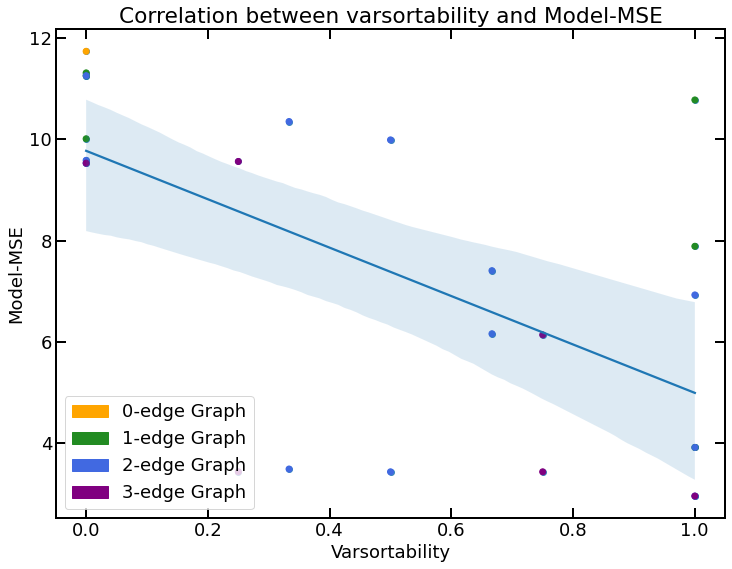

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
colors = ['orange', 'forestgreen', 'forestgreen', 'forestgreen', 'forestgreen', 'forestgreen', 'forestgreen', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'royalblue', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple']
ax.tick_params(which='major', size=10, width=2, direction='in', right='on', top='on')
ax.tick_params(which='minor', size=7, width=2, direction='in', right='on', top='on')
ax.scatter(list(df['Var-Sort']), list(df['MSE(Model)']), c=colors)
sns.regplot(df['Var-Sort'], df['MSE(Model)'], scatter_kws={'zorder': -1}, ax=ax)
plt.title('Correlation between varsortability and Model-MSE')
plt.xlabel('Varsortability')
plt.ylabel('Model-MSE')
patches = [mp.Patch(color='orange', label='0-edge Graph'), mp.Patch(color='forestgreen', label='1-edge Graph'), mp.Patch(color='royalblue', label='2-edge Graph'), mp.Patch(color='purple', label='3-edge Graph')]
plt.legend(handles=patches, loc='lower left')
plt.savefig('varsortability_mse_corr.svg')

Since NT optimizes for DAGs, one of the 25 graphs shown in this 3 node case is certainly the solution (when converged), furthermore, NT is allegedly only optimizing Model MSE (variances) which means it will be one of the top graphs, *furthermore, a perfect varsortability suggests that NT can simply sort the variances for easier MSE computation* so it will be one of the top graphs shown there - since they are all pretty much same MSE wise, it would feel like it always chooses one of those. (Furthermore, NT regularizes for sparsity, kicks out 2 as well because of 3 edges.)

Let's try different parameters, different graphs, in hope of a pattern.

In [194]:
a1 = 1
a2 = 1

N1 = np.random.normal(0, 1, 10000)
N2 = np.random.normal(0, 1, 10000)
N3 = np.random.normal(0, 1, 10000)

#X1 = N1
#X2 = a1*X1 + N2
#X3 = a2*X2 + N3
X1 = N1
X3 = N3
X2 = a1*X1 + a2*X3 + N2

X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
X3 = X3.reshape(-1,1)

v = np.hstack([X1,X2,X3])
v[:,0] *= 10
models_scored = []
model_1, model_2 = None, None
for i in range(3+1):
    for m in models[str(i)]:
        lrs_m = lin_model(m, v)
        mse_m = mse_model(m, lrs_m, v)
        if m == [(1,3,2)]:
            model_1 = lrs_m
        if m == [(3,2,1),(3,2)]:
            model_2 = lrs_m
        #print(f'Model ({i} edges): {str(m)}\t\t MSE(M)={mse_m:.2f}')
        models_scored.append((m, i, mse_m))
df = pd.DataFrame(models_scored, columns=["Model", "Number of Edges", "MSE(Model)"])
vs = []
for i in range(3+1):
    for m in models[str(i)]:
        vs.append(varsort(model_to_adj(m), v))
df['Var-Sort'] = vs
df.sort_values(['MSE(Model)'], ascending=[True]).round(2)

,Model,Number of Edges,MSE(Model),Var-Sort
20,"[(3, 2, 1), (3, 2)]",3,52.52,1.00
24,"[(3, 2, 1), (2, 3)]",3,53.20,0.75
16,"[(3, 2, 1)]",2,53.53,1.00
8,"[(2, 1), (3, 2)]",2,68.62,1.00
23,"[(1, 2, 3), (2, 1)]",3,69.13,0.25
10,"[(2, 1), (2, 3)]",2,69.29,0.50
15,"[(1, 3), (2, 1)]",2,69.63,0.33
5,"[(2, 1)]",1,69.63,1.00
22,"[(3, 1), (1, 3, 2)]",3,99.48,0.75
21,"[(1, 3), (1, 3, 2)]",3,99.49,0.25


In [195]:
w1, w2 = model_1[0][0].coef_
w2_hat = model_2[1][0].coef_[0]
w1_hat, w3 = model_2[0][0].coef_

In [196]:
cov_1_3 = np.cov(v[:, 0], v[:, 2])[0, 1]
cov_2_3 = np.cov(v[:, 1], v[:, 2])[0, 1]
cov_1_2 = np.cov(v[:, 0], v[:, 1])[0, 1]
var_x1 = v[:, 0].var()
var_x2 = v[:, 1].var()
var_x3 = v[:, 2].var()
lhs = w1**2 * var_x1 + w2**2 * var_x3 + 2*w1*w2*cov_1_3 - 2*w1*cov_1_2 - 2*w2*cov_2_3
rhs = w2_hat**2*var_x3 -2*w2_hat*cov_2_3 + w1_hat**2*var_x2 + w3**2*var_x3 + 2*w1_hat*w3*cov_2_3 - 2*w1_hat*cov_1_2 - 2*w3*cov_1_3
print(f"w_2^2*Var(X1) + 2w_1w_2*Cov(X1, X3) = {lhs} < {rhs} = w_2^2*Var(X2) + w_3^2*Var(X3) + 2w_1w_2*Cov(X2, X3) - 2w_3*Cov(X1, X3)")

w_2^2*Var(X1) + 2w_1w_2*Cov(X1, X3) = -1.978309580796653 < 144.16976397281027 = w_2^2*Var(X2) + w_3^2*Var(X3) + 2w_1w_2*Cov(X2, X3) - 2w_3*Cov(X1, X3)


06.05.22, Experiment

Given a chain, it suffices to change the variance ordering of first-last node pair only, to have a lower MSE in the changed one (i.e., NT can still choose to do collider since that is the exact varsortation, but MSE of attacked will be lower of truth as well).

In [83]:
a1 = 1
a2 = 1

N1 = np.random.normal(0, 1, 10000)
N2 = np.random.normal(0, 1, 10000)
N3 = np.random.normal(0, 1, 10000)

X1 = N1
X2 = a1*X1 + N2
X3 = a2*X2 + N3

X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
X3 = X3.reshape(-1,1)

v = np.hstack([X1,X2,X3])

print(f'X1.shape {X1.shape}, X2.shape {X2.shape}, X3.shape {X3.shape}')
print(f'Var(X1)  = {v[:,0].var():.2f} = V_1 = {N1.var():.2f}')
print(f'Var(X2) = {v[:,1].var():.2f} and V_2 = {N2.var():.2f}')
print(f'Var(X3) = {v[:,2].var():.2f} and V_3 = {N3.var():.2f}')

models_scored = []
models = [[(1,2),(2,3)],[(3,2),(2,1)],[(1,2),(3,2)]]
for m in models:
    lrs_m = lin_model(m, v)
    mse_m = mse_model(m, lrs_m, v)
    models_scored.append((m, mse_m))
df = pd.DataFrame(models_scored, columns=["Model", "MSE(Model)"])
print(df)

# now perform scaling (attack)
models_scored = []
v[:,0] = 4*v[:,0]
print("\n\n After Attack:")
print(f'Var(X1)  = {v[:,0].var():.2f} = V_1 = {N1.var():.2f}')
print(f'Var(X2) = {v[:,1].var():.2f} and V_2 = {N2.var():.2f}')
print(f'Var(X3) = {v[:,2].var():.2f} and V_3 = {N3.var():.2f}')
for m in models:
    lrs_m = lin_model(m, v)
    mse_m = mse_model(m, lrs_m, v)
    models_scored.append((m, mse_m))
df = pd.DataFrame(models_scored, columns=["Model", "MSE(Model)"])
print(df)

X1.shape (10000, 1), X2.shape (10000, 1), X3.shape (10000, 1)
Var(X1)  = 1.00 = V_1 = 1.00
Var(X2) = 1.99 and V_2 = 1.00
Var(X3) = 2.98 and V_3 = 0.99
              Model  MSE(Model)
0  [(1, 2), (2, 3)]    2.988193
1  [(3, 2), (2, 1)]    4.143841
2  [(1, 2), (3, 2)]    5.640829


 After Attack:
Var(X1)  = 15.96 = V_1 = 1.00
Var(X2) = 1.99 and V_2 = 1.00
Var(X3) = 2.98 and V_3 = 0.99
              Model  MSE(Model)
0  [(1, 2), (2, 3)]   17.959242
1  [(3, 2), (2, 1)]   11.662533
2  [(1, 2), (3, 2)]   20.611878


### Regular 2-node Case $A\rightarrow B$ or $A\leftarrow B$

This is the regular setting from Reisach et al.
It is important to note that $MSE(M)$ is for some model $M$ and refers to the sum of all residuals.
I.e., $MSE(X) = \sum_i (Y-aX)^2 = Var(Y-aX)$ whereas $MSE(M) = \sum_i MSE(X_i)$ with $MSE(X)=0$ if $X$ is not predicted.

In [81]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

In [138]:
np.random.seed(0)
w = 0.5
NX = np.random.normal(0, 1, 10000)
NY = np.random.normal(0, 1, 10000)
X = NX
Y = w*X + NY
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

In [139]:
print(f'Var(X) = V_X = {X.var():.2f}')
print(f'Var(Y) = {Y.var():.2f} and V_Y = {NY.var():.2f}')

Var(X) = V_X = 1.18
Var(Y) = 1.22 and V_Y = 0.99


In [140]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X, Y)
pred_x_y = lr.predict(X)

In [141]:
mse_x_y = mean_squared_error(Y, pred_x_y)

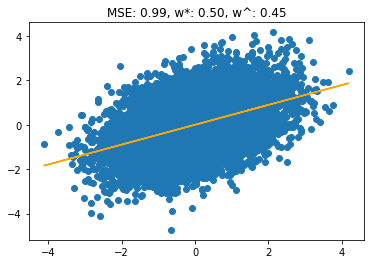

In [142]:
import matplotlib.pyplot as plt
plt.scatter(X,Y)
plt.plot(X,pred_x_y,c="orange")
plt.title(f'MSE: {mse_x_y:.2f}, w*: {w:.2f}, w^: {lr.coef_[0][0]:.2f}')
plt.show()

In [143]:
lr2 = LinearRegression(fit_intercept=False)
lr2.fit(Y, X)
pred_y_x = lr2.predict(Y)

In [144]:
mse_y_x = mean_squared_error(X, pred_y_x)

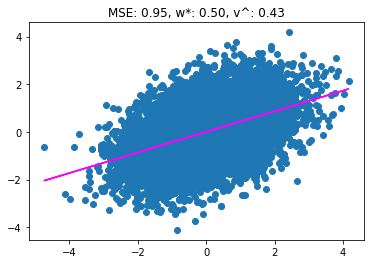

In [145]:
plt.scatter(Y,X)
plt.plot(Y,pred_y_x,c="magenta")
plt.title(f'MSE: {mse_y_x:.2f}, w*: {w:.2f}, v^: {lr2.coef_[0][0]:.2f}')
plt.show()

In [146]:
cov_XY = np.cov(np.hstack((X, Y)).T)
print(cov_XY) # cov(X,X) = var(X) and cov(Y,Y) = var(Y) and cov(X,Y) = cov(Y,X))
print(f'w^ = {lr.coef_[0][0]:.2f} approx cov(X,Y)/var(X) = {cov_XY[0,1]/cov_XY[0,0]:.2f}\n'
     f'v^ = {lr2.coef_[0][0]:.2f} approx cov(X,Y)/var(Y) = {cov_XY[0,1]/cov_XY[1,1]:.2f}')

[[1.18019227 0.52807974]
 [0.52807974 1.22248734]]
w^ = 0.45 approx cov(X,Y)/var(X) = 0.45
v^ = 0.43 approx cov(X,Y)/var(Y) = 0.43


Here we simply assert that the coefficients that we learned match the analytical derivation.

In [147]:
print(np.allclose(pred_x_y, lr.coef_[0][0]*X))
print(np.allclose(pred_y_x, lr2.coef_[0][0]*Y))

True
True


If we only consider the MSE of $y$, the equivalence relation does not hold necessarily:

In [148]:
print(f'MSE = {mse_x_y:.2f} < {mse_y_x:.2f} = MSE '
      '<==>'
      f' [Var(X) {cov_XY[0,0]:.2f} + Var(Y-w^X) {np.var(Y-pred_x_y):.2f}] = {cov_XY[0,0]+np.var(Y-pred_x_y):.2f} '
     f'< {cov_XY[1,1]+np.var(X-pred_y_x):.2f} = [Var(Y) {cov_XY[1,1]:.2f} + Var(X-v^Y) {np.var(X-pred_y_x):.2f}]\n')

MSE = 0.99 < 0.95 = MSE <==> [Var(X) 1.18 + Var(Y-w^X) 0.99] = 2.17 < 2.17 = [Var(Y) 1.22 + Var(X-v^Y) 0.95]



Indeed, if we have the proper $MSE(M)$ which adds to $V(B-wA)$ the term $V(A)$ (since $A$ is not predicted), then the inequality holds and $MSE$ infers the right model.

In [149]:
print(f'MSE(M1) = {mse_x_y + mean_squared_error(np.zeros_like(X), X):.2f} < {mse_y_x + mean_squared_error(np.zeros_like(Y), Y):.2f} = MSE(M2) '
      '<==>'
      f' [Var(X) {cov_XY[0,0]:.2f} + Var(Y-w^X) {np.var(Y-pred_x_y):.2f}] = {cov_XY[0,0]+np.var(Y-pred_x_y):.2f} '
     f'< {cov_XY[1,1]+np.var(X-pred_y_x):.2f} = [Var(Y) {cov_XY[1,1]:.2f} + Var(X-v^Y) {np.var(X-pred_y_x):.2f}]\n')

MSE(M1) = 2.17 < 2.17 = MSE(M2) <==> [Var(X) 1.18 + Var(Y-w^X) 0.99] = 2.17 < 2.17 = [Var(Y) 1.22 + Var(X-v^Y) 0.95]

